# Compute the number of background counts

In [6]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

In [37]:
from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset

In [8]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
observations = data_store.get_observations()

In [9]:
observations[0].pointing_zen

<Quantity 38.512962 deg>

In [29]:
n_events = []
zen_pnt = []
for obs in observations:
    ev1 = obs.events.select_offset([0, 2.3] * u.deg)
    ev2 = ev1.select_energy([1.0, 10.0] * u.TeV)
    num = len(ev2.table)
    n_events.append(num)
    zen_pnt.append(obs.pointing_zen.value)

Text(0, 0.5, 'number of events')

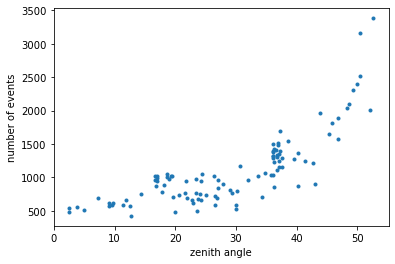

In [30]:
plt.plot(zen_pnt, n_events, '.')
plt.xlabel('zenith angle')
plt.ylabel('number of events')

In [40]:
def make_bkg(obs):
    energy_axis = MapAxis.from_energy_bounds(1.0, 10.0, 1, unit="TeV")
    geom = WcsGeom.create(
        skydir=obs.pointing_radec,
        binsz=0.1,
        width=(5, 5),
        frame="icrs",
        proj="CAR",
        axes=[energy_axis],
    )
    offset_max = 2.3 * u.deg
    stacked = MapDataset.create(geom=geom)
    maker = MapDatasetMaker()
    
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    return dataset

In [41]:
counts = []
bkg = []
for i,obs in enumerate(observations):
    if i%10 == 0:
        print(i)
    dataset = make_bkg(obs)
    counts.append(dataset.counts.data.sum())
    bkg.append(dataset.background.data.sum())

0
10
20
30
40
50
60
70
80
90
100


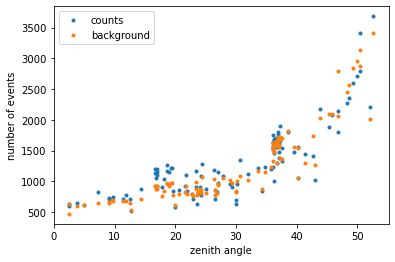

In [44]:
plt.plot(zen_pnt, counts, '.', label='counts')
plt.plot(zen_pnt, bkg, '.', label='background')
plt.xlabel('zenith angle')
plt.ylabel('number of events')
plt.legend()